# PINN for Inverse Problem: Estimating Young's Modulus
# ======================================================
### This code uses a Physics-Informed Neural Network (PINN) to estimate the Young's modulus (E) of a linear elastic material based on observed displacements under known loading.
## The model learns to match a known PDE (1D bar under axial load) using displacement data.


## Governing Equation:
## ----------------------
### For a 1D bar under axial load in linear elasticity:
###    $$ d/dx (EA * du/dx) = 0         ... (1) $$
### where:
###   E  = Young's modulus (Pa)
###  A  = Cross-sectional area (m²) (assumed constant)
###  u(x) = displacement at position x (m)
### This simplifies to:
###    $$ E * d²u/dx² = 0                ... (2) $$
### since A is constant.
### PINNs solve this equation by minimizing the residual of (2) during training.

In [91]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [92]:
#  Physical Setup: 1D bar under axial load
L = 1.0  # Length of bar (m)
A = 1.0  # Cross-sectional area (m^2)
F = 1.0  # Applied force at x = L (N)
E_true = 210e9  # True Young's modulus (Pa) [e.g., Steel]

In [93]:
#  Generate synthetic displacement data (u = Fx / AE)

# 🔢 Generate synthetic displacement data (u = Fx / AE)
x_data = np.linspace(0, L, 100).reshape(-1, 1)
u_data = (F * x_data) / (A * E_true)
x_mean, x_std = x_data.mean(), x_data.std()
u_mean, u_std = u_data.mean(), u_data.std()

x_norm = (x_data - x_mean) / x_std
u_norm = (u_data - u_mean) / u_std
x_train = torch.tensor(x_norm, dtype=torch.float32, requires_grad=True)
u_train = torch.tensor(u_norm, dtype=torch.float32)

In [166]:
#  Define PINN model (1 input x → 1 output u)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 60),
            nn.Tanh(),
            nn.Linear(60, 60),
            nn.Tanh(),
            nn.Linear(60, 60),
            nn.Tanh(),
            nn.Linear(60, 1)
        )
    def forward(self, x):
        return self.net(x)

model = Net()
log_E = torch.tensor([np.log(2e11)], requires_grad=True, dtype=torch.float32)
optimizer = torch.optim.Adam(list(model.parameters()) + [log_E], lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)


In [167]:
#  Loss: Physics residual of 1D equilibrium equation: d/dx(EA du/dx) = 0
def total_loss(x, u_train_norm):
    u_pred_norm = model(x)
    du_dx = torch.autograd.grad(u_pred_norm, x, torch.ones_like(u_pred_norm), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]
    E = torch.exp(log_E)
    physics_loss = torch.mean((E * d2u_dx2)**2)
    data_loss = torch.mean((u_pred_norm - u_train_norm)**2)
    return physics_loss + 0.1 * data_loss
    


In [168]:
# Training loop
losses = []
for epoch in range(5000):
    optimizer.zero_grad()
    loss = total_loss(x_train, u_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    scheduler.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.2e}, Estimated E: {torch.exp(log_E).item():.2e} Pa")
    scheduler.step()

Epoch 0, Loss: 5.86e+19, Estimated E: 2.00e+11 Pa
Epoch 20, Loss: 4.12e+18, Estimated E: 2.00e+11 Pa
Epoch 40, Loss: 8.43e+17, Estimated E: 2.00e+11 Pa
Epoch 60, Loss: 4.32e+17, Estimated E: 2.00e+11 Pa
Epoch 80, Loss: 3.01e+17, Estimated E: 2.00e+11 Pa
Epoch 100, Loss: 2.28e+17, Estimated E: 2.00e+11 Pa
Epoch 120, Loss: 1.76e+17, Estimated E: 2.00e+11 Pa
Epoch 140, Loss: 1.35e+17, Estimated E: 2.00e+11 Pa
Epoch 160, Loss: 1.03e+17, Estimated E: 2.00e+11 Pa
Epoch 180, Loss: 7.92e+16, Estimated E: 2.00e+11 Pa
Epoch 200, Loss: 6.07e+16, Estimated E: 2.00e+11 Pa
Epoch 220, Loss: 4.65e+16, Estimated E: 2.00e+11 Pa
Epoch 240, Loss: 3.55e+16, Estimated E: 2.00e+11 Pa
Epoch 260, Loss: 2.70e+16, Estimated E: 2.00e+11 Pa
Epoch 280, Loss: 2.04e+16, Estimated E: 2.00e+11 Pa
Epoch 300, Loss: 1.53e+16, Estimated E: 2.00e+11 Pa
Epoch 320, Loss: 1.14e+16, Estimated E: 2.00e+11 Pa
Epoch 340, Loss: 8.46e+15, Estimated E: 2.00e+11 Pa
Epoch 360, Loss: 6.22e+15, Estimated E: 2.00e+11 Pa
Epoch 380, Loss: 4

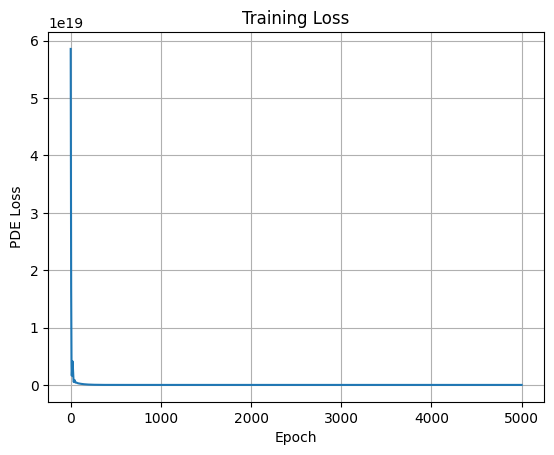

In [169]:
#  Plot loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("PDE Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()


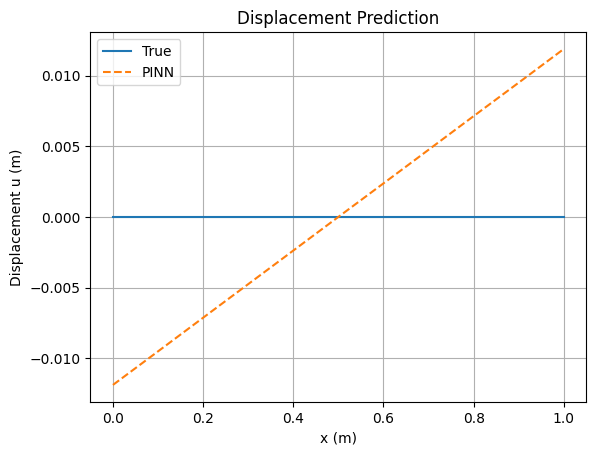


True E: 2.10e+11 Pa
Estimated E from PINN: 2.00e+11 Pa


In [170]:

#  Compare predicted vs true displacement
with torch.no_grad():
    u_pred = model(x_train).numpy()

plt.plot(x_data, u_data, label="True")
plt.plot(x_data, u_pred, '--', label="PINN")
plt.xlabel("x (m)")
plt.ylabel("Displacement u (m)")
plt.legend()
plt.title("Displacement Prediction")
plt.grid(True)
plt.show()

#  Final estimate of Young's Modulus
print(f"\nTrue E: {E_true:.2e} Pa")
print(f"Estimated E from PINN: {torch.exp(log_E).item():.2e} Pa")


In [ ]:
|